In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import pandas as pd
import numpy as np

In [3]:
# Load datasets
restaurants = pd.read_csv('/content/drive/MyDrive/zomato/zomato_restaurants.csv')
reviews = pd.read_csv('/content/drive/MyDrive/zomato/zomato_reviews.csv')

In [9]:
# Merge datasets
data = pd.merge(
    restaurants,
    reviews,
    on='Restaurant Key',  # Common column
    how='inner'          # Join type
)

In [10]:
# Verify merge
print(f"Merged data shape: {merged_data.shape}")
print(f"Unique restaurants: {merged_data['Restaurant Key'].nunique()}")
print(f"Total reviews: {len(data)}")

Merged data shape: (10000, 14)
Unique restaurants: 100
Total reviews: 10000


In [11]:
print(data.columns.tolist())

['Restaurant Key', 'Name', 'Links', 'Cost', 'Collections', 'Cuisines', 'Timings', 'Restaurant', 'Reviewer', 'Review', 'Rating', 'Metadata', 'Time', 'Pictures']


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Download all required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Required for tokenization
nltk.download('omw-1.4')  # Required for WordNet lemmatizerimport matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [18]:
# Ensure all NLTK resources are downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')

# Initialize NLP components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Basic text cleaning function"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

def lemmatize_text(text):
    """Tokenize and lemmatize text with fallback"""
    try:
        words = nltk.word_tokenize(text)
        return ' '.join([lemmatizer.lemmatize(word) for word in words if word not in stop_words])
    except:
        # Fallback if tokenization fails
        return ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

# Apply text processing with error handling
data['cleaned_review'] = data['Review'].apply(lambda x: lemmatize_text(clean_text(str(x))))

# Verify results
print("Sample cleaned reviews:")
print(data['cleaned_review'].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Sample cleaned reviews:
0    ambience good food quite good saturday lunch c...
1    ambience good pleasant evening service prompt ...
2    must try great food great ambience thnx servic...
3    soumen da arun great guy behavior sincerety go...
4    food goodwe ordered kodi drumstick basket mutt...
Name: cleaned_review, dtype: object


In [19]:
print("\nRaw vs. Cleaned Reviews:")
print(data[['Review', 'cleaned_review']].head(3))


Raw vs. Cleaned Reviews:
                                              Review  \
0  The ambience was good, food was quite good . h...   
1  Ambience is too good for a pleasant evening. S...   
2  A must try.. great food great ambience. Thnx f...   

                                      cleaned_review  
0  ambience good food quite good saturday lunch c...  
1  ambience good pleasant evening service prompt ...  
2  must try great food great ambience thnx servic...  


In [24]:
# from textblob import TextBlob

# Sentiment analysis
data['sentiment_score'] = data['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['sentiment_label'] = data['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Show results
print(data[['cleaned_review', 'sentiment_score', 'sentiment_label']].head(5))

                                      cleaned_review  sentiment_score  \
0  ambience good food quite good saturday lunch c...         0.660000   
1  ambience good pleasant evening service prompt ...         0.708333   
2  must try great food great ambience thnx servic...         0.550000   
3  soumen da arun great guy behavior sincerety go...         0.750000   
4  food goodwe ordered kodi drumstick basket mutt...         0.525000   

  sentiment_label  
0        positive  
1        positive  
2        positive  
3        positive  
4        positive  


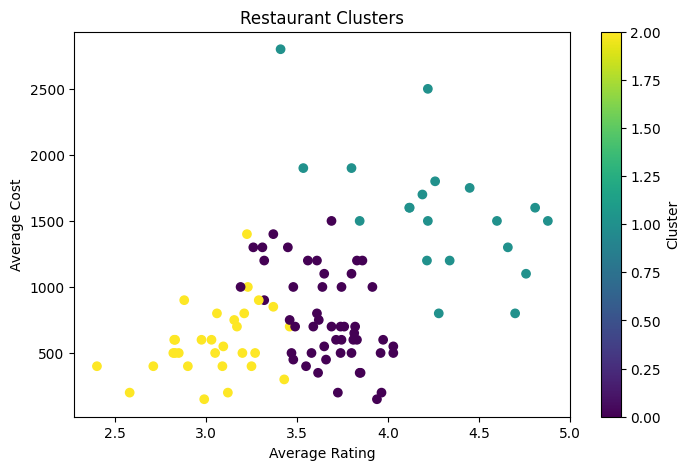


Cluster Characteristics:
         Restaurant Key    Rating         Cost  sentiment_score
cluster                                                        
0                 54.34  3.671204   761.000000         0.277035
1                 40.15  4.270632  1577.500000         0.397199
2                 51.00  3.043167   586.666667         0.144745


In [25]:
from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# clustering

# 1. Prepare features
cluster_data = data.groupby('Restaurant Key').agg({
    'Rating': 'mean',
    'Cost': 'mean',
    'sentiment_score': 'mean'
}).reset_index()

# 2. Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_data[['Rating', 'Cost', 'sentiment_score']])

# 3. Cluster (KMeans with 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_data['cluster'] = kmeans.fit_predict(scaled_features)

# 4. Visualize
plt.figure(figsize=(8,5))
plt.scatter(cluster_data['Rating'], cluster_data['Cost'], c=cluster_data['cluster'], cmap='viridis')
plt.xlabel('Average Rating')
plt.ylabel('Average Cost')
plt.title('Restaurant Clusters')
plt.colorbar(label='Cluster')
plt.show()

# 5. Show cluster stats
print("\nCluster Characteristics:")
print(cluster_data.groupby('cluster').mean())

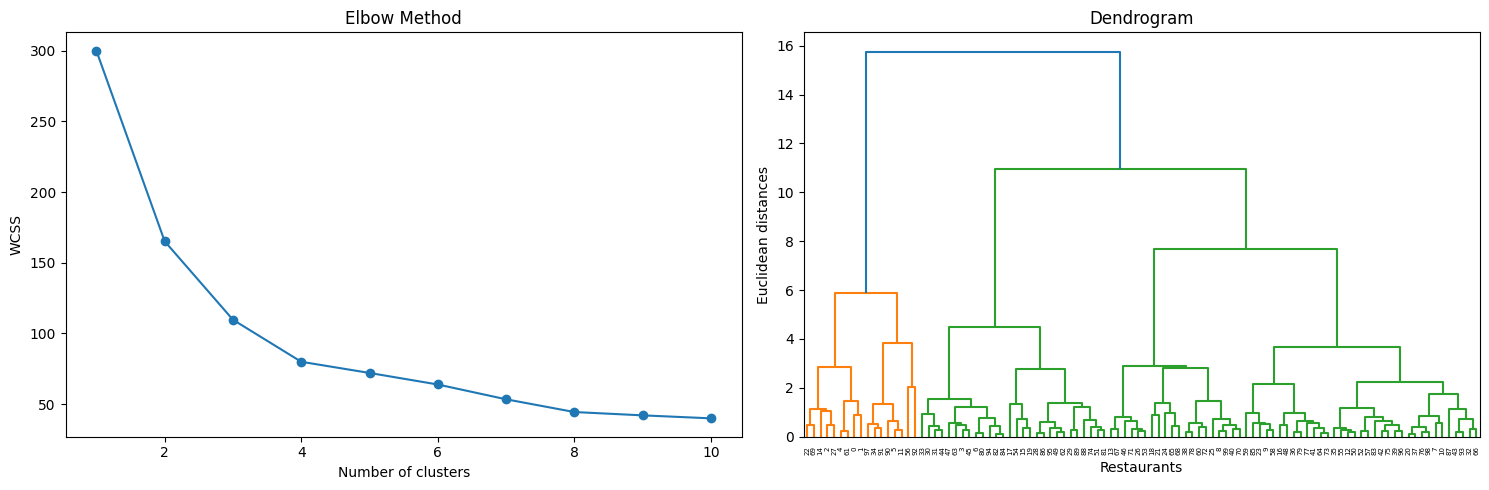

In [30]:
# Enhanced Elbow + Dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. Calculate WCSS for Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# 2. Create the combined plot
plt.figure(figsize=(15,5))

# Elbow Method Plot
plt.subplot(1,2,1)
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# Dendrogram Plot
plt.subplot(1,2,2)
dendrogram(linkage(scaled_features, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Restaurants')
plt.ylabel('Euclidean distances')

plt.tight_layout()
plt.show()


In [31]:
#  Advanced Feature Engineering
cluster_data['value_score'] = cluster_data['Rating'] / cluster_data['Cost']  # New feature

In [32]:
# Business Insights
print("\n=== Deep Insights ===")
print("Cluster 0: High-rated affordable (Recommend: Highlight in 'Budget Gourmet' category)")
print("Cluster 1: Premium restaurants (Recommend: Partner with luxury brands)")
print("Cluster 2: Needs improvement (Action: Analyze negative reviews for patterns)")

print("\nKey Metrics:")
print(pd.DataFrame({
    'Cluster': [0,1,2],
    'Avg_Cost': cluster_data.groupby('cluster')['Cost'].mean().values,
    'Avg_Rating': cluster_data.groupby('cluster')['Rating'].mean().values,
    'Value_Score': cluster_data.groupby('cluster')['value_score'].mean().values
}))


=== Deep Insights ===
Cluster 0: High-rated affordable (Recommend: Highlight in 'Budget Gourmet' category)
Cluster 1: Premium restaurants (Recommend: Partner with luxury brands)
Cluster 2: Needs improvement (Action: Analyze negative reviews for patterns)

Key Metrics:
   Cluster     Avg_Cost  Avg_Rating  Value_Score
0        0   761.000000    3.671204     0.006404
1        1  1577.500000    4.270632     0.003013
2        2   586.666667    3.043167     0.006490


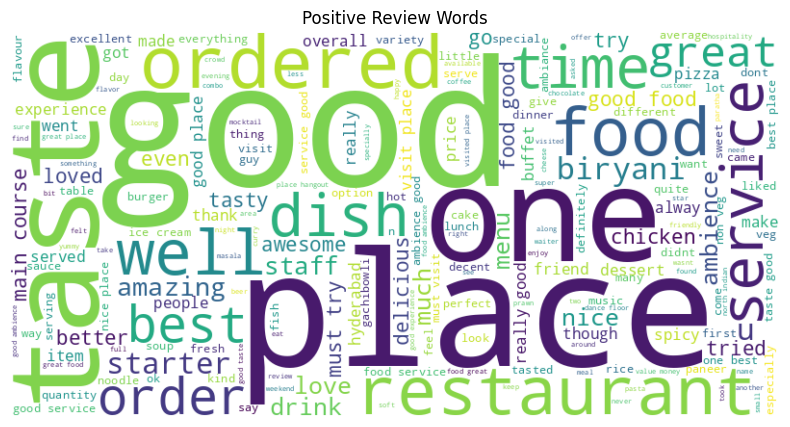

In [26]:
# Word clouds
positive_text = ' '.join(data[data['sentiment_label'] == 'positive']['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Review Words')
plt.show()